<a href="https://colab.research.google.com/github/SNOOthiking/SHOPPING/blob/snoo/dacon_winner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon 쇼핑몰 매출 예측 경진대회 우승팀 부산대학교산업공학과 코드 

- 데이터를 분석하기 전에 데이터를 먼저 살펴보고 방향성을 잡는 연습을 해야겠다. 

코드 분석 ~ 

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/dacon_shopping2/shopping2_git/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dacon_shopping2/shopping2_git/dataset/test.csv')
print("Train subset column : {}".format(train.columns))
print("Test subset column : {}".format(test.columns))


Train subset column : Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales'],
      dtype='object')
Test subset column : Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday'],
      dtype='object')


## 모든 Store 판매 그래프 보기 

In [6]:
from matplotlib import dates

fig = plt.figure(figsize=(50,50)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 색상 설정

for i in range(1,46):
    train2 = train[train.Store == i]

    train2  = train2[["Date", "Weekly_Sales"]]
    
    ax = fig.add_subplot(10,10,i) ## 그림 뼈대(프레임) 생성


    plt.title("store_{}".format(i)) 
    plt.ylabel('Weekly_Sales')
    plt.xticks(rotation=15)
    ax.xaxis.set_major_locator(dates.MonthLocator(interval = 2))
    ax.plot(train2["Date"], train2["Weekly_Sales"],marker='',label='train', color="blue")

plt.show()

- 주 단위의 판매량을 시계열 데이터로 생각하였습니다. 각 Store의 주 판매량을 그래프로 확인하니 특정 Store끼리 유사한 것으로 판단하여 더욱 정확한 예측을 위해 Store별로 Type을 만드는 군집화를 진행할 예정입니다..
## 군집화 clustering / 주어진 데이터 집합을 유사한 그룹으로 묶는 것 . 
- 나는 왜 스토어별 모델링을 적용했을까?

## 음수값 확인

- 음수값이 있는지도 몰랐다.. 이번 분석은 실수가 엄청 많았다.

In [7]:
print("Train set의 Promotion의 음수값")
print(sum(train['Promotion1'] < 0))
print(sum(train['Promotion2'] < 0))
print(sum(train['Promotion3'] < 0))
print(sum(train['Promotion4'] < 0))
print(sum(train['Promotion5'] < 0))

print("Test set의 Promotion의 음수값")
print(sum(test['Promotion1'] < 0))
print(sum(test['Promotion2'] < 0))
print(sum(test['Promotion3'] < 0))
print(sum(test['Promotion4'] < 0))
print(sum(test['Promotion5'] < 0))

Train set의 Promotion의 음수값
0
18
4
0
0
Test set의 Promotion의 음수값
0
1
0
0
0


In [10]:
# 결측치 확인
print("Train subset 결측치 : \n")
print(train.isna().sum())

print("Test subset 결측치 : \n")
print(test.isna().sum())

Train subset 결측치 : 

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64
Test subset 결측치 : 

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64


## 결측치, 음수값 -> 0 처리

In [11]:

train['Promotion2'][train['Promotion2'] < 0] = 0
train['Promotion3'][train['Promotion3'] < 0] = 0

test['Promotion2'][test['Promotion2'] < 0] = 0

# Fill 0 on missing value
train.fillna(0, inplace=True)
test.fillna(0, inplace = True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    6255 non-null   float64
 6   Promotion2    6255 non-null   float64
 7   Promotion3    6255 non-null   float64
 8   Promotion4    6255 non-null   float64
 9   Promotion5    6255 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    180 non-null    float64
 6   Promotion2    180 non-null    float64
 7   Promotion3    180 non-null    float64
 8   Promotion4    180 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB


## Date Format 변환 

- 날짜 컬럼은 시계열 분석할때는 datetime으로 XGB를 이용할땐 사용하지 않았는데 이분것을 보니 중요한 요소가 될 수 있다는것을 깨달았습니다.


In [14]:
# 일/월/년도 식의 format은 보기 분편해서 임의로 편하게 바꿔주었다.
date_df = train.loc[:, ['Date']]


for i in range(len(date_df)) :
    date_list =  date_df.loc[i].str.split('/')
    date_df.loc[i] = date_list[0][2] + '-' + date_list[0][1] + '-' + date_list[0][0]

train['Date'] = date_df

# Change type of 'Date' : object to datedime
train['Date'] = pd.to_datetime(train["Date"])
train['week'] =train['Date'].dt.week
train['month'] =train['Date'].dt.month 
train['year'] =train['Date'].dt.year
train['WeekOfYear'] = (train.Date.dt.isocalendar().week)*1.0 
train['day'] = train['Date'].dt.day

date_df = test.loc[:, ['Date']]
for i in range(len(date_df)) :
    date_list =  date_df.loc[i].str.split('/')
    date_df.loc[i] = date_list[0][2] + '-' + date_list[0][1] + '-' + date_list[0][0]

test['Date'] = date_df

# Change type of 'Date' : object to datedime
test['Date'] = pd.to_datetime(test["Date"])
test['week'] =test['Date'].dt.week
test['month'] =test['Date'].dt.month 
test['year'] =test['Date'].dt.year
test['WeekOfYear'] = (test.Date.dt.isocalendar().week)*1.0 
test['day'] = test['Date'].dt.day

In [16]:
train.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'week', 'month', 'year', 'WeekOfYear',
       'day'],
      dtype='object')

## 각 Store의 연도별 판매량 확인

- 이와같이 데이터를 다양하게 살펴보는 것 또한 해야겠습니다.

In [ ]:
train

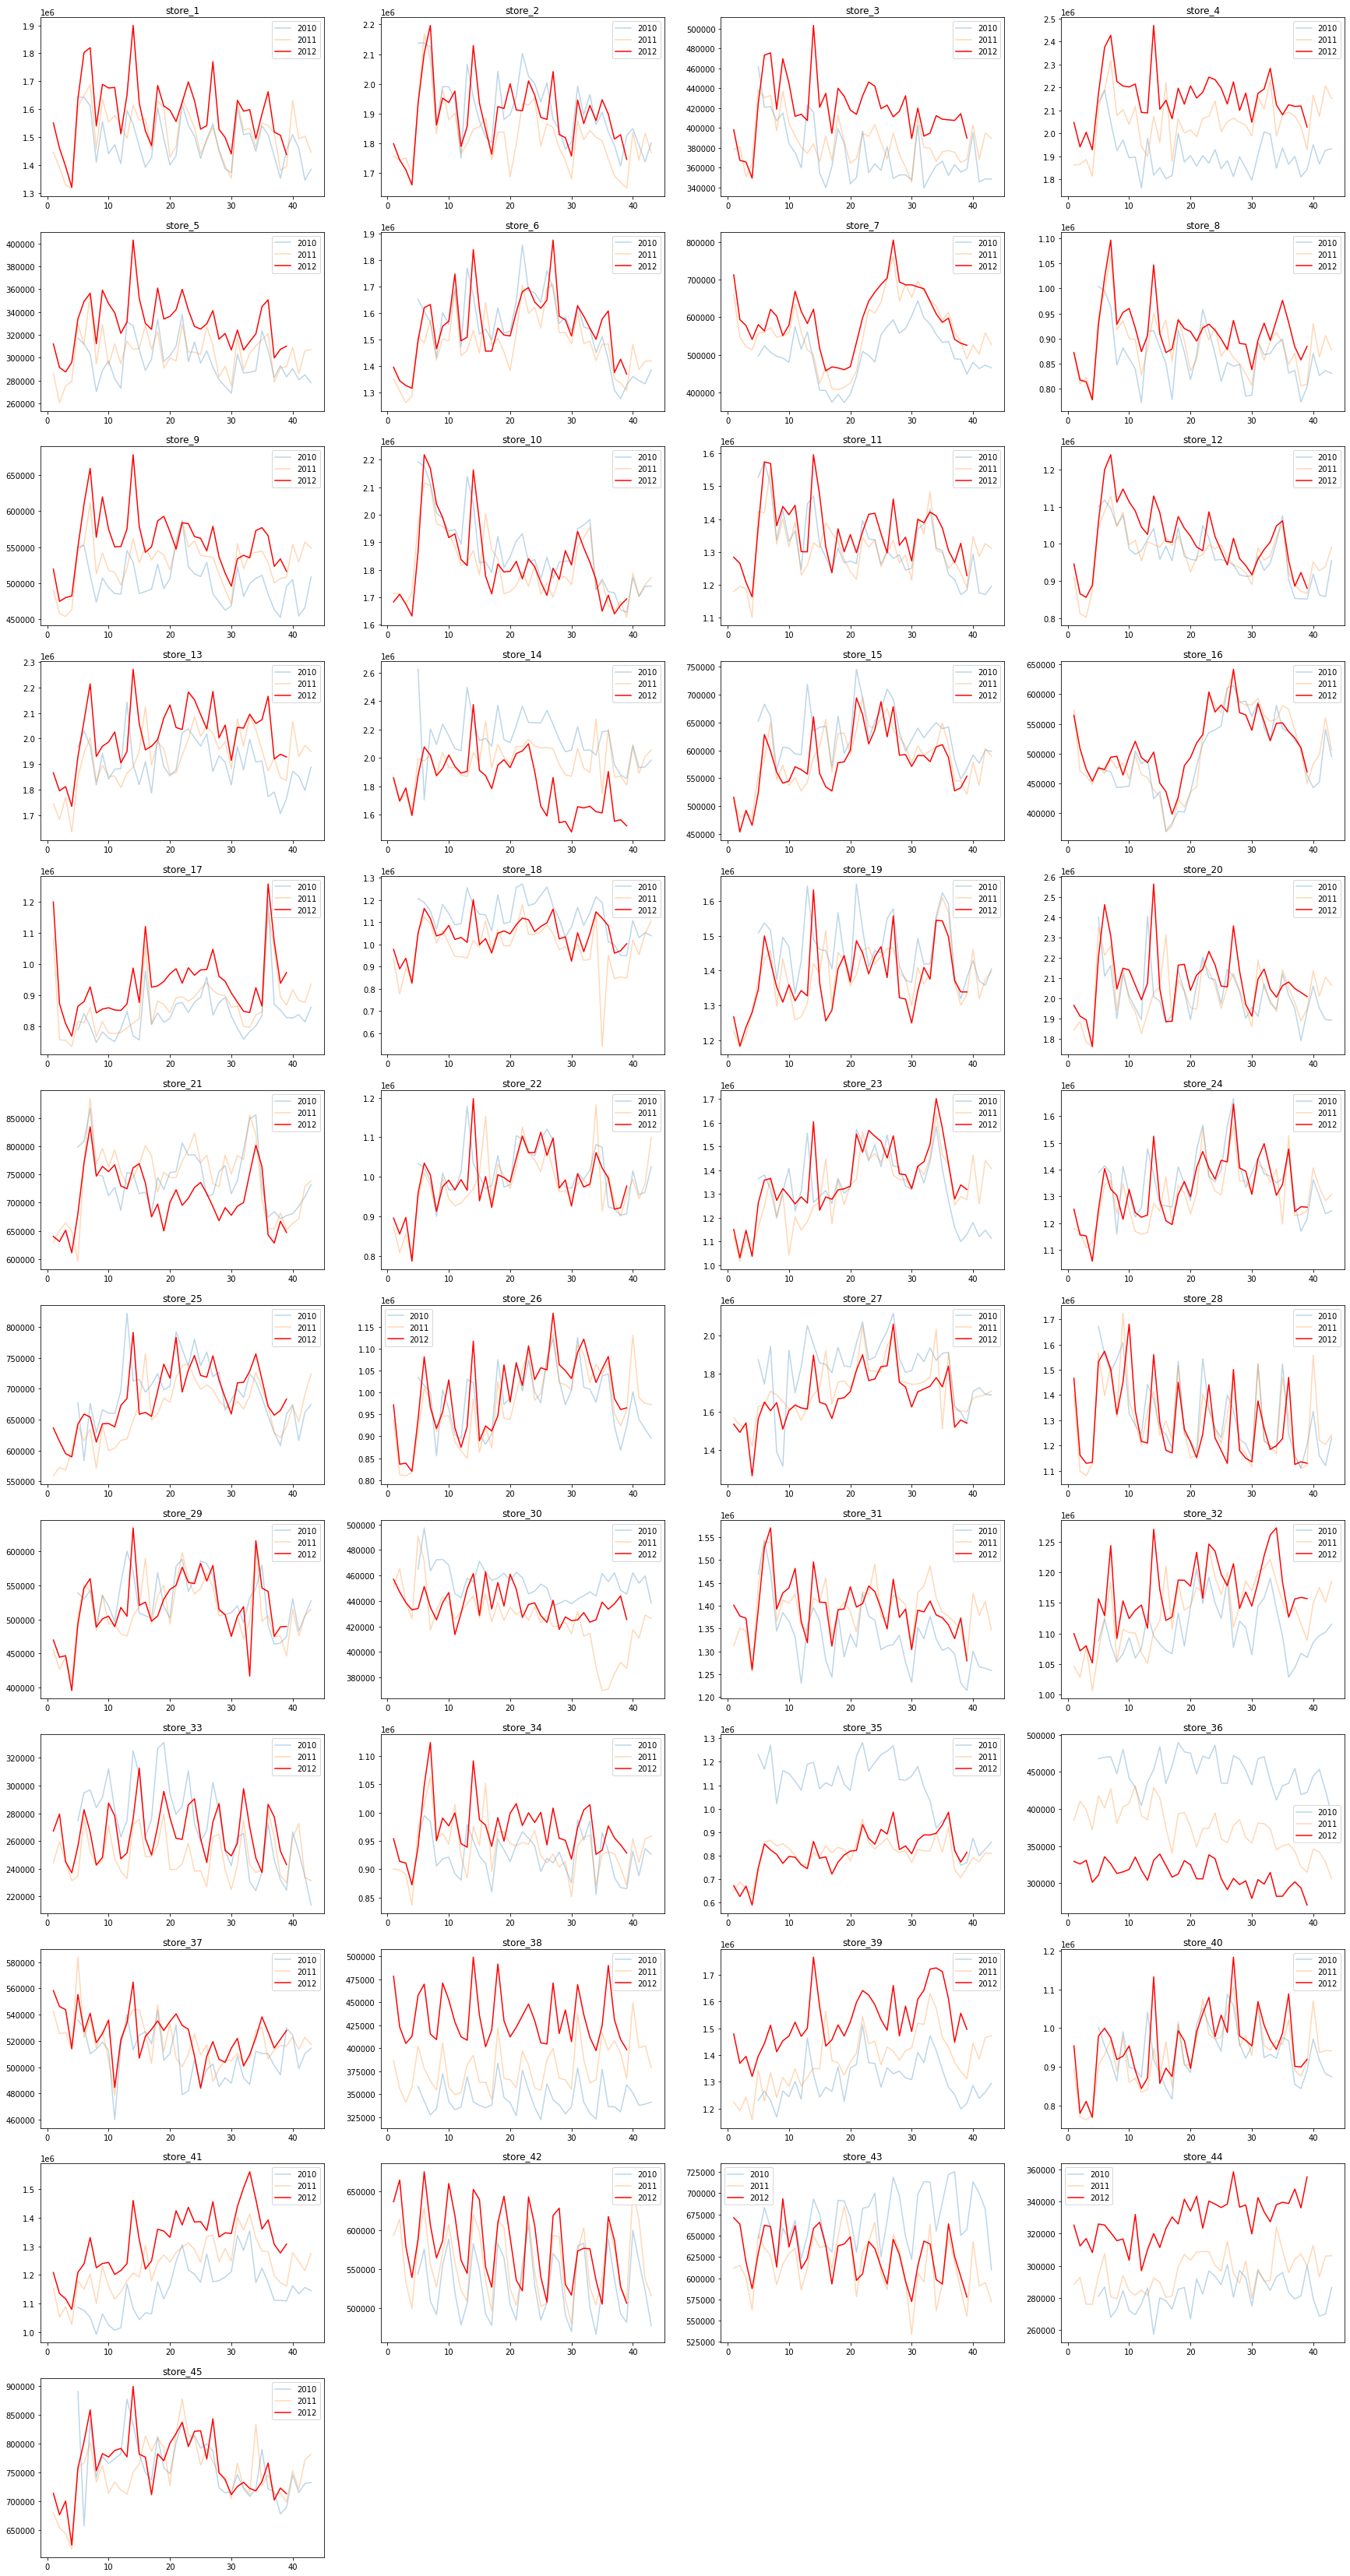

In [43]:
fig = plt.figure(figsize=(30,60))
train_df = train
for store in range(1,46):
    storeset = train_df[train_df.Store==store]
    storeset_2010 = storeset[(storeset.year==2010) & (storeset.WeekOfYear<=43)]
    storeset_2011 = storeset[(storeset.year==2011) & (storeset.WeekOfYear<=43)]
    storeset_2012 = storeset[(storeset.year==2012) & (storeset.WeekOfYear<=43)]
    
    ax = fig.add_subplot(12, 4, store)
    
    plt.title(f"store_{store}")
    ax.plot(list(storeset_2010.WeekOfYear), list(storeset_2010.Weekly_Sales), label="2010", alpha=0.3) # alpha = 투명도 list로 묶어야 1D array로 표현해서 플롯 그릴수 있음
    ax.plot(list(storeset_2011.WeekOfYear), list(storeset_2011.Weekly_Sales), label="2011", alpha=0.3)
    ax.plot(list(storeset_2012.WeekOfYear), list(storeset_2012.Weekly_Sales), label="2012", color='r')
    #ax.plot(test_pred_store.WeekOfYear, test_pred_store.Before_Weekly_Sales, label="2012-pred", color='b')
    ax.legend()
    
plt.show()

## Box plot 이상치 확인 

In [ ]:
# Train
col_list = list(train.columns)
col_list.remove('Date')
col_list.remove('id')
col_list.remove('IsHoliday')
for column in col_list:
    fig = plt.figure(figsize=(20,5))
    sns.boxplot(train[column], color='yellow')
    fig.show()

## 시계열 군집화 

- 내가 하지 않았던 것 중 가장 중요하다고 생각하는 군집화
- 위 2010년 11년 12년 그래프를 통해 각 스토어마다 10년 11년 12년 그래프의 유사성을 확인할 수 있었고 시계열 군집화를 진행한다.

In [46]:
pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.2 MB/s 


In [47]:
from tslearn.clustering import TimeSeriesKMeans

scaled_time_series_df = pd.DataFrame()
for num in range(1, 46) :
    col_name = "Store " +str(num)
    scaler = MinMaxScaler()
    # test 셋은 2012년 10월 데이터이기 때문에 각 연도별 10월(포함) 이전의 시계열 데이터의 유사성을 판단하여 type을 나누었습니다.
    time_series = train[(train.Store==num) & (train.month <= 10)]['Weekly_Sales'].values.reshape(-1, 1)
    scaled_time_series = scaler.fit_transform(time_series) 
    scaled_time_series = pd.DataFrame(scaled_time_series)
    scaled_time_series_df[col_name] = scaled_time_series

transpose_scaled_time_series_df = scaled_time_series_df.transpose()
    
km = TimeSeriesKMeans(n_clusters=3,  # 클러스터의 개수 그래프를 확인하고 몇개의 군집으로 나눌 것인지 판단. 최종적으로 가장 좋은 군집을 설정하는게 베스트
                      metric="dtw", 
                      max_iter=5,
                      random_state=2022)

prediction = km.fit_predict(transpose_scaled_time_series_df)

list_0 = []
list_1 = []
list_2 = []

for i in range(len(prediction)) :
    if prediction[i] == 0 :
        list_0.append(i+1)
    elif prediction[i] == 1 :
        list_1.append(i+1)
    else:
        list_2.append(i+1)

print("Clustering 0 : ", list_0)
print("Clustering 1 : ", list_1)
print("Clustering 2 : ", list_2)

for i in range(len(prediction)) :
    if prediction[i] == 0 :
        train.loc[(train.Store == i + 1), 'Type'] = 0
        test.loc[(test.Store == i + 1), 'Type'] = 0
    elif prediction[i] == 1 :
        train.loc[(train.Store == i + 1), 'Type'] = 1
        test.loc[(test.Store == i + 1), 'Type'] = 1
    else:
        train.loc[(train.Store == i + 1), 'Type'] = 2
        test.loc[(test.Store == i + 1), 'Type'] = 2

Clustering 0 :  [6, 13, 15, 19, 21, 22, 23, 24, 25, 26, 27, 29, 32, 37, 40, 43, 45]
Clustering 1 :  [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 20, 28, 31, 33, 34, 38, 39, 41, 42, 44]
Clustering 2 :  [14, 18, 30, 35, 36]


## 공휴일 구분하기

- 1위 팀은 특정 공휴일이 영향을 줄 것이다 라고 판단한 것 같다. 예를들어 슈퍼볼, 노동절, 추수감사절, 크리스마스 같은 경우를 말이다. 앞으로 시계열 데이터 분석할 때 참고하면 좋을 것같다. 파생변수를 만들었다.

In [49]:
#%%
train.loc[(train['Date'] == '2010-02-12')|(train['Date'] == '2011-02-11')|(train['Date'] == '2012-02-10'),'Super_Bowl'] = True
train.loc[(train['Date'] != '2010-02-12')&(train['Date'] != '2011-02-11')&(train['Date'] != '2012-02-10'),'Super_Bowl'] = False

# Labor day dates in train set
train.loc[(train['Date'] == '2010-09-10')|(train['Date'] == '2011-09-09')|(train['Date'] == '2012-09-07'),'Labor_Day'] = True
train.loc[(train['Date'] != '2010-09-10')&(train['Date'] != '2011-09-09')&(train['Date'] != '2012-09-07'),'Labor_Day'] = False

# Thanksgiving dates in train set
train.loc[(train['Date'] == '2010-11-26')|(train['Date'] == '2011-11-25'),'Thanksgiving'] = True
train.loc[(train['Date'] != '2010-11-26')&(train['Date'] != '2011-11-25'),'Thanksgiving'] = False

#Christmas dates in train set
train.loc[(train['Date'] == '2010-12-31')|(train['Date'] == '2011-12-30'),'Christmas'] = True
train.loc[(train['Date'] != '2010-12-31')&(train['Date'] != '2011-12-30'),'Christmas'] = False

train['Super_Bowl'] = train['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
train['Thanksgiving'] = train['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
train['Labor_Day'] = train['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
train['Christmas'] = train['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
train['IsHoliday'] = train['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1
#%%

test.loc[(test['Date'] == '2010-02-12')|(test['Date'] == '2011-02-11')|(test['Date'] == '2012-02-10'),'Super_Bowl'] = True
test.loc[(test['Date'] != '2010-02-12')&(test['Date'] != '2011-02-11')&(test['Date'] != '2012-02-10'),'Super_Bowl'] = False

# Labor day dates in train set
test.loc[(test['Date'] == '2010-09-10')|(test['Date'] == '2011-09-09')|(test['Date'] == '2012-09-07'),'Labor_Day'] = True
test.loc[(test['Date'] != '2010-09-10')&(test['Date'] != '2011-09-09')&(test['Date'] != '2012-09-07'),'Labor_Day'] = False

# Thanksgiving dates in train set
test.loc[(test['Date'] == '2010-11-26')|(test['Date'] == '2011-11-25'),'Thanksgiving'] = True
test.loc[(test['Date'] != '2010-11-26')&(test['Date'] != '2011-11-25'),'Thanksgiving'] = False

#Christmas dates in train set
test.loc[(test['Date'] == '2010-12-31')|(test['Date'] == '2011-12-30'),'Christmas'] = True
test.loc[(test['Date'] != '2010-12-31')&(test['Date'] != '2011-12-30'),'Christmas'] = False

test['Super_Bowl'] = test['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
test['Thanksgiving'] = test['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
test['Labor_Day'] = test['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
test['Christmas'] = test['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
test['IsHoliday'] = test['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [60]:

sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=train)


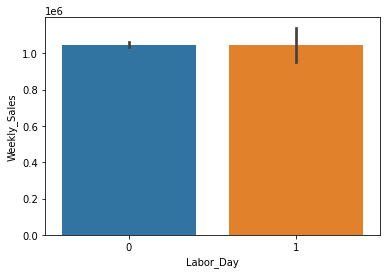

In [61]:
 
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=train) 

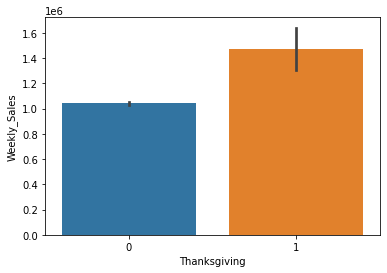

In [62]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=train)  # 추석때 판매량이 증가

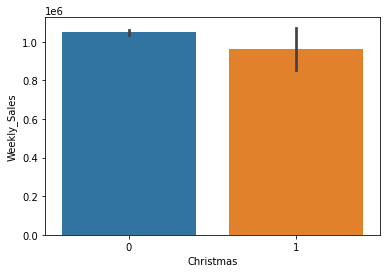

In [64]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=train) 


## Correlation 상관관계 


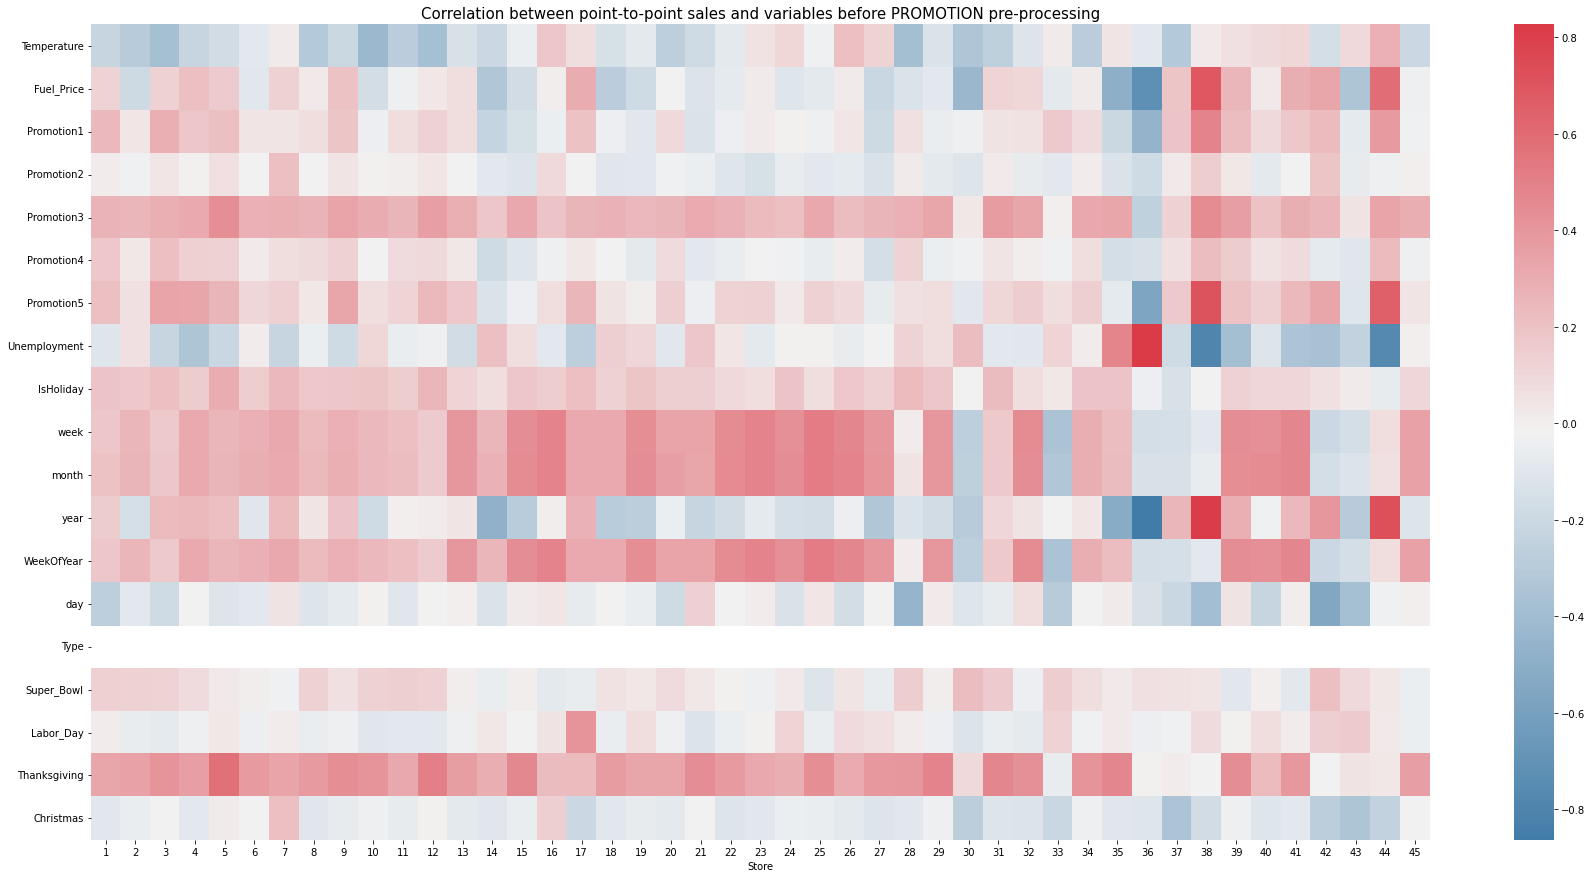

In [73]:
# Analyze Correlation by Store
corr = []
for num in range(1,46):
    co = train[train.Store==num]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['index', 'id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(30,15))
plt.title("Correlation between point-to-point sales and variables before PROMOTION pre-processing", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('Store')
plt.show()

## 년도별 상관관계 확인 

- 시계열데이터는 년도별로도 확인해 보는것도 좋아보인다.

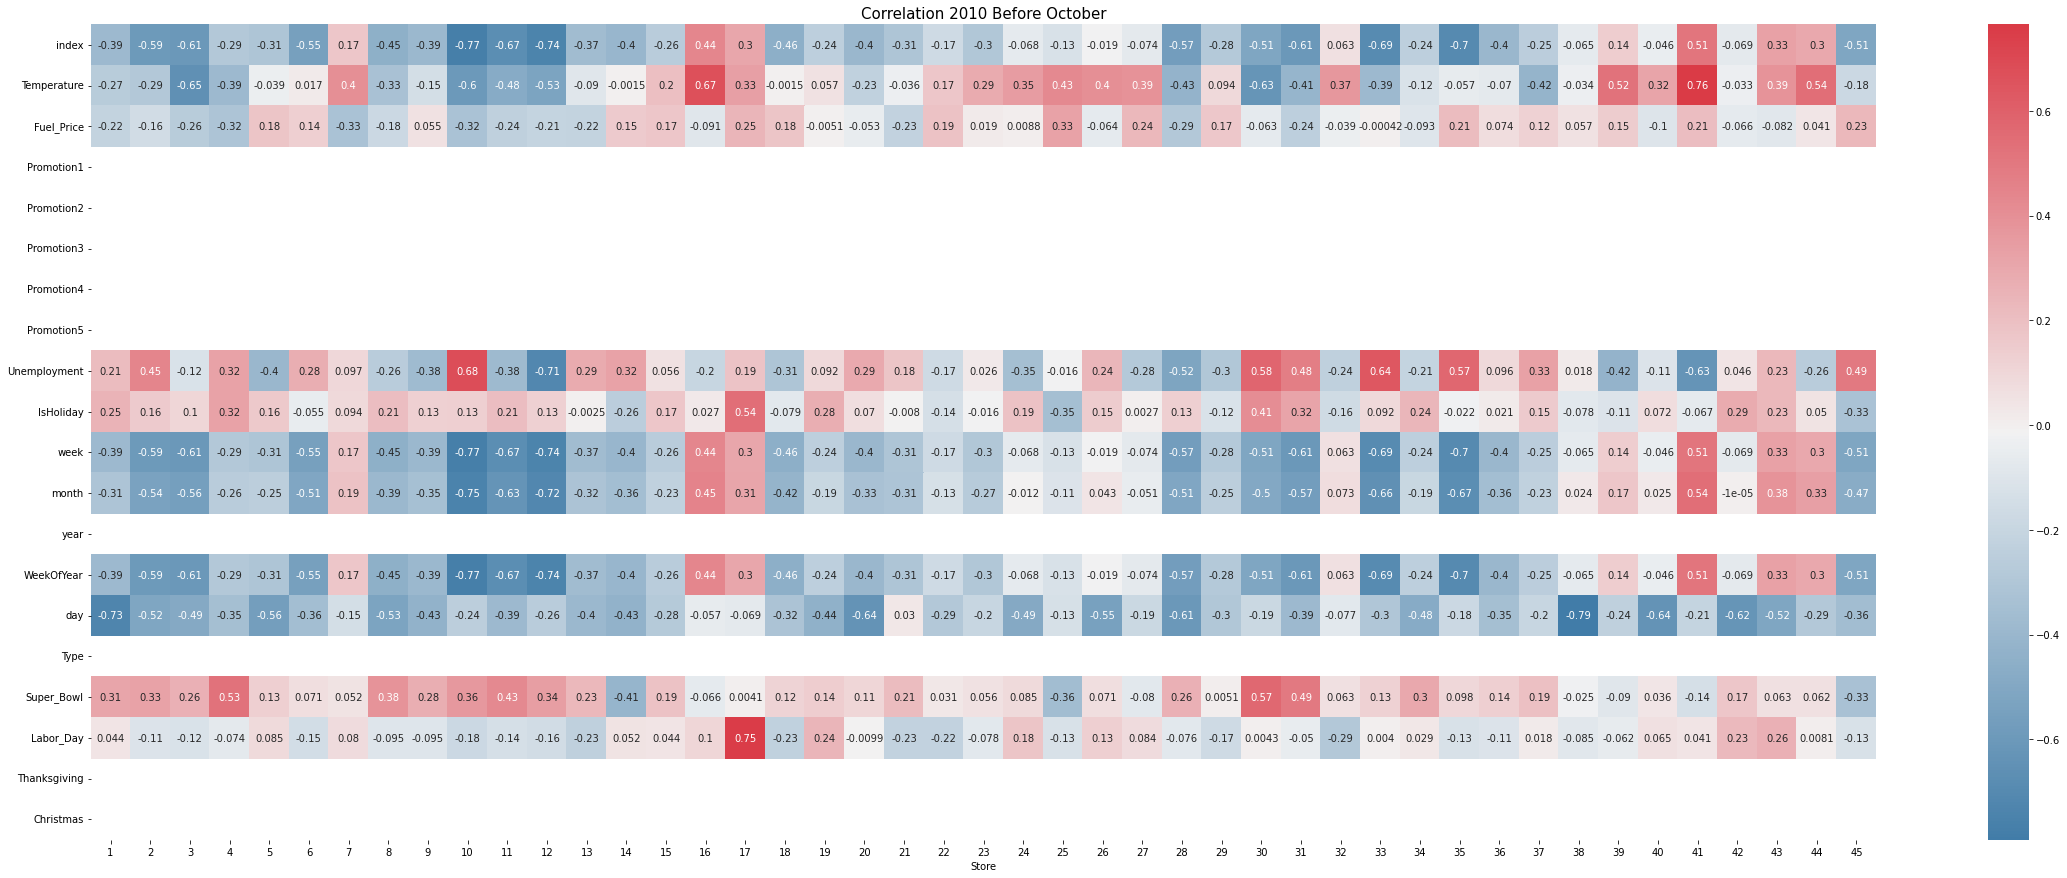

In [75]:
# Analyze Correlation by Store 
# 10월 이전만 한 이유는 12년경우 10월 이후가 없기 때문이다.
corr = []
for num in range(1,46):
    co = train[(train.Store==num) & (train.year==2010) & (train.month <= 10)]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(40, 15))
plt.title("Correlation 2010 Before October", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot=True)
plt.xlabel('Store')
plt.show()
#%%

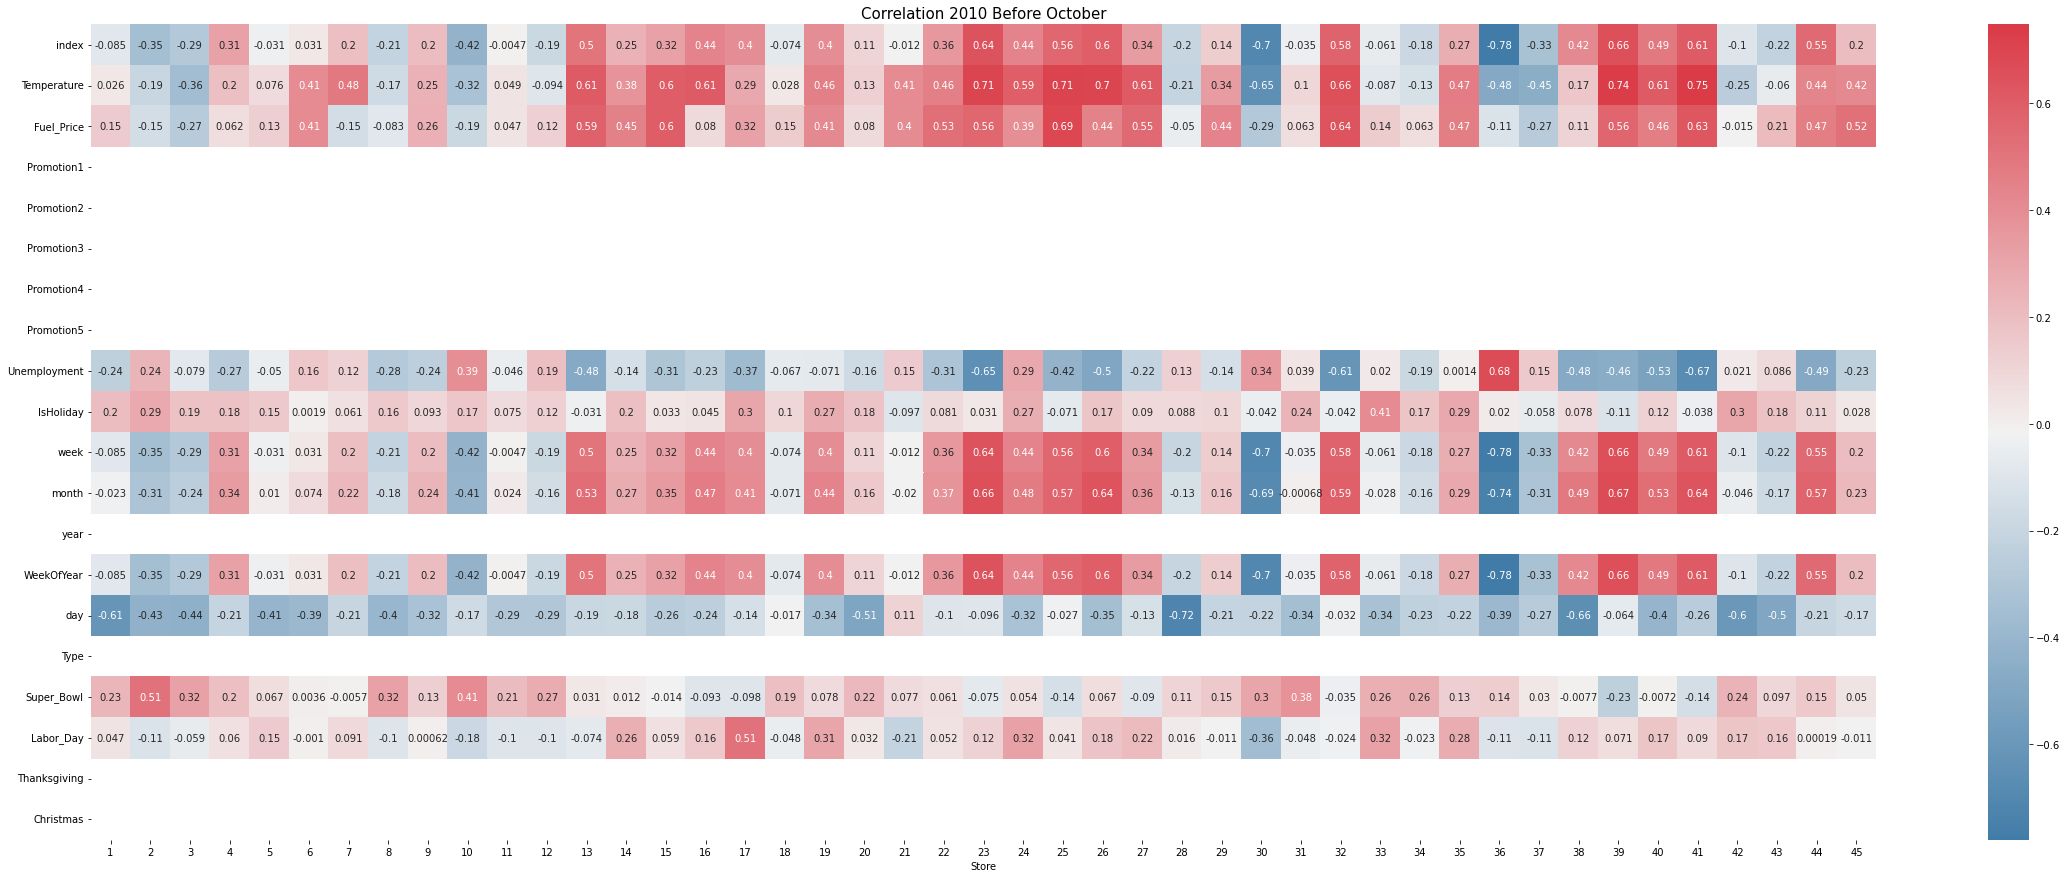

In [77]:
# Analyze Correlation by Store 
# 10월 이전만 한 이유는 12년경우 10월 이후가 없기 때문이다.
corr = []
for num in range(1,46):
    co = train[(train.Store==num) & (train.year==2011) & (train.month <= 10)]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(40, 15))
plt.title("Correlation 2010 Before October", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot=True)
plt.xlabel('Store')
plt.show()
#%%

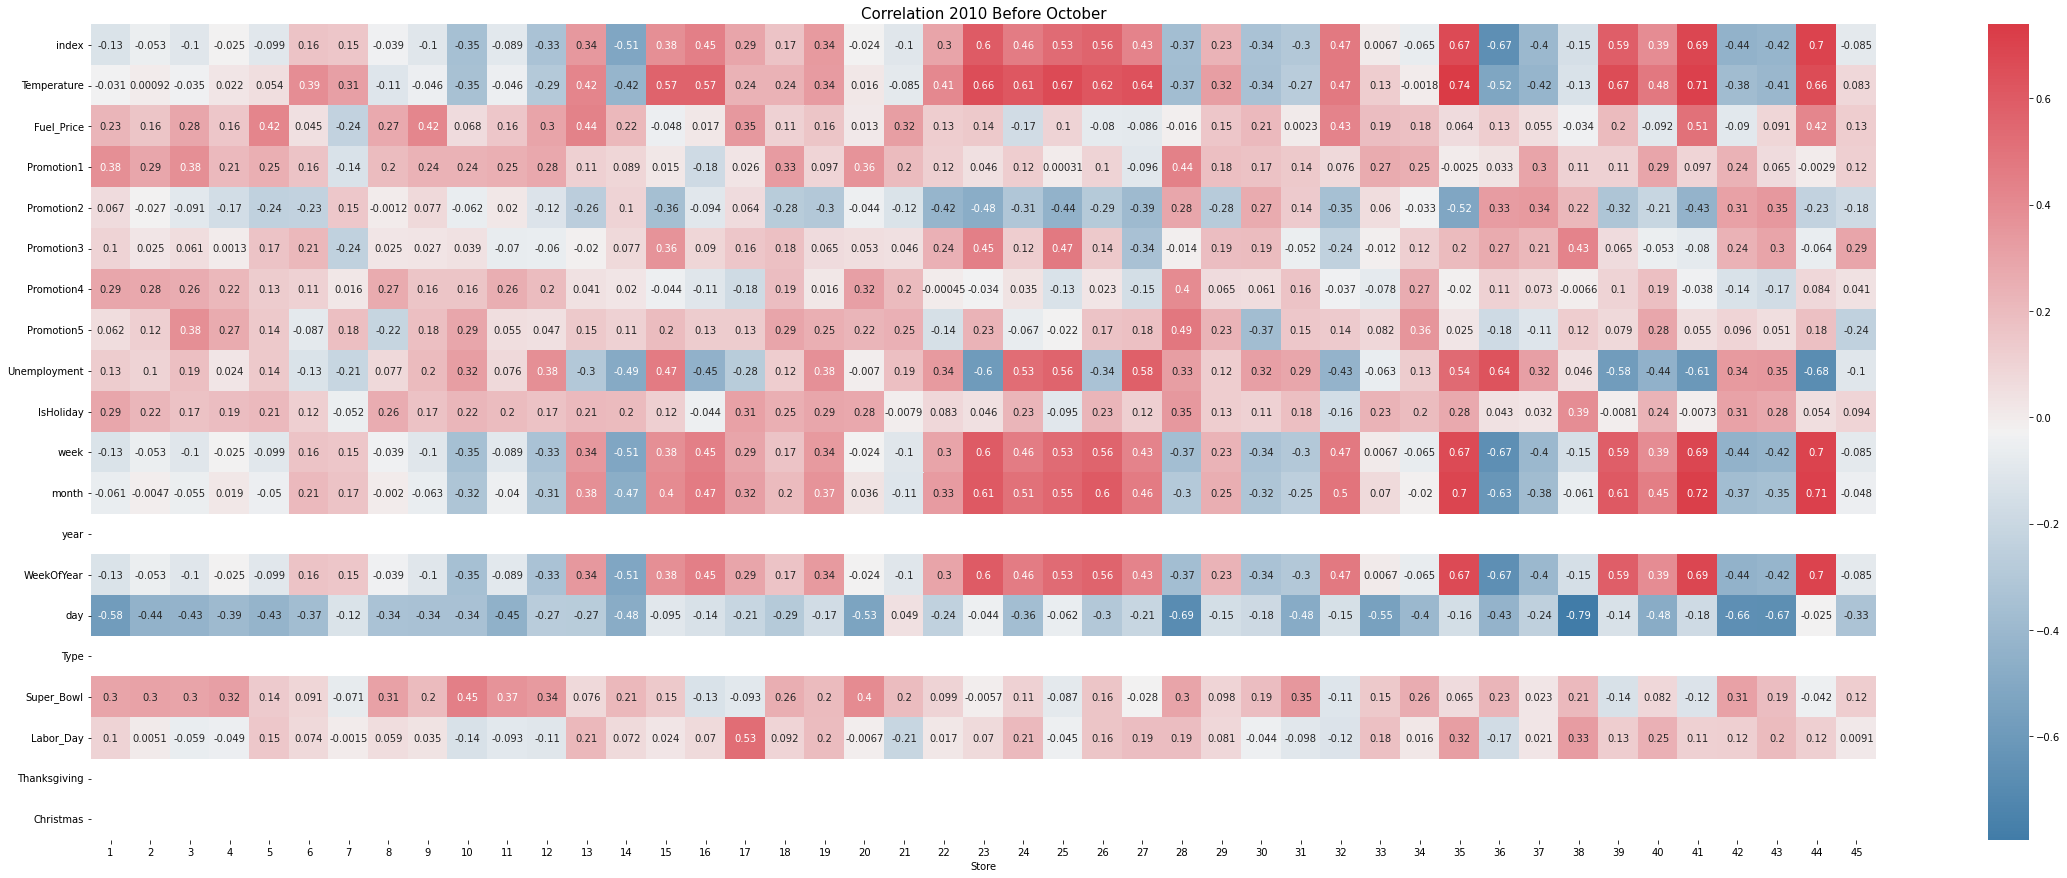

In [78]:
# Analyze Correlation by Store 
# 10월 이전만 한 이유는 12년경우 10월 이후가 없기 때문이다.
corr = []
for num in range(1,46):
    co = train[(train.Store==num) & (train.year==2012) & (train.month <= 10)]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(40, 15))
plt.title("Correlation 2010 Before October", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot=True)
plt.xlabel('Store')
plt.show()
#%%

## 그렇다면 우리가 예측해야할 10월 한달의 corr을 확인해보자

In [79]:
# Analyze Correlation by Store 
# 10월 이전만 한 이유는 12년경우 10월 이후가 없기 때문이다.
corr = []
for num in range(1,46):
    co = train[(train.Store==num) & (train.year==2010) & (train.month == 10)]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(40, 15))
plt.title("Correlation 2010 Before October", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot=True)
plt.xlabel('Store')
plt.show()
#%%

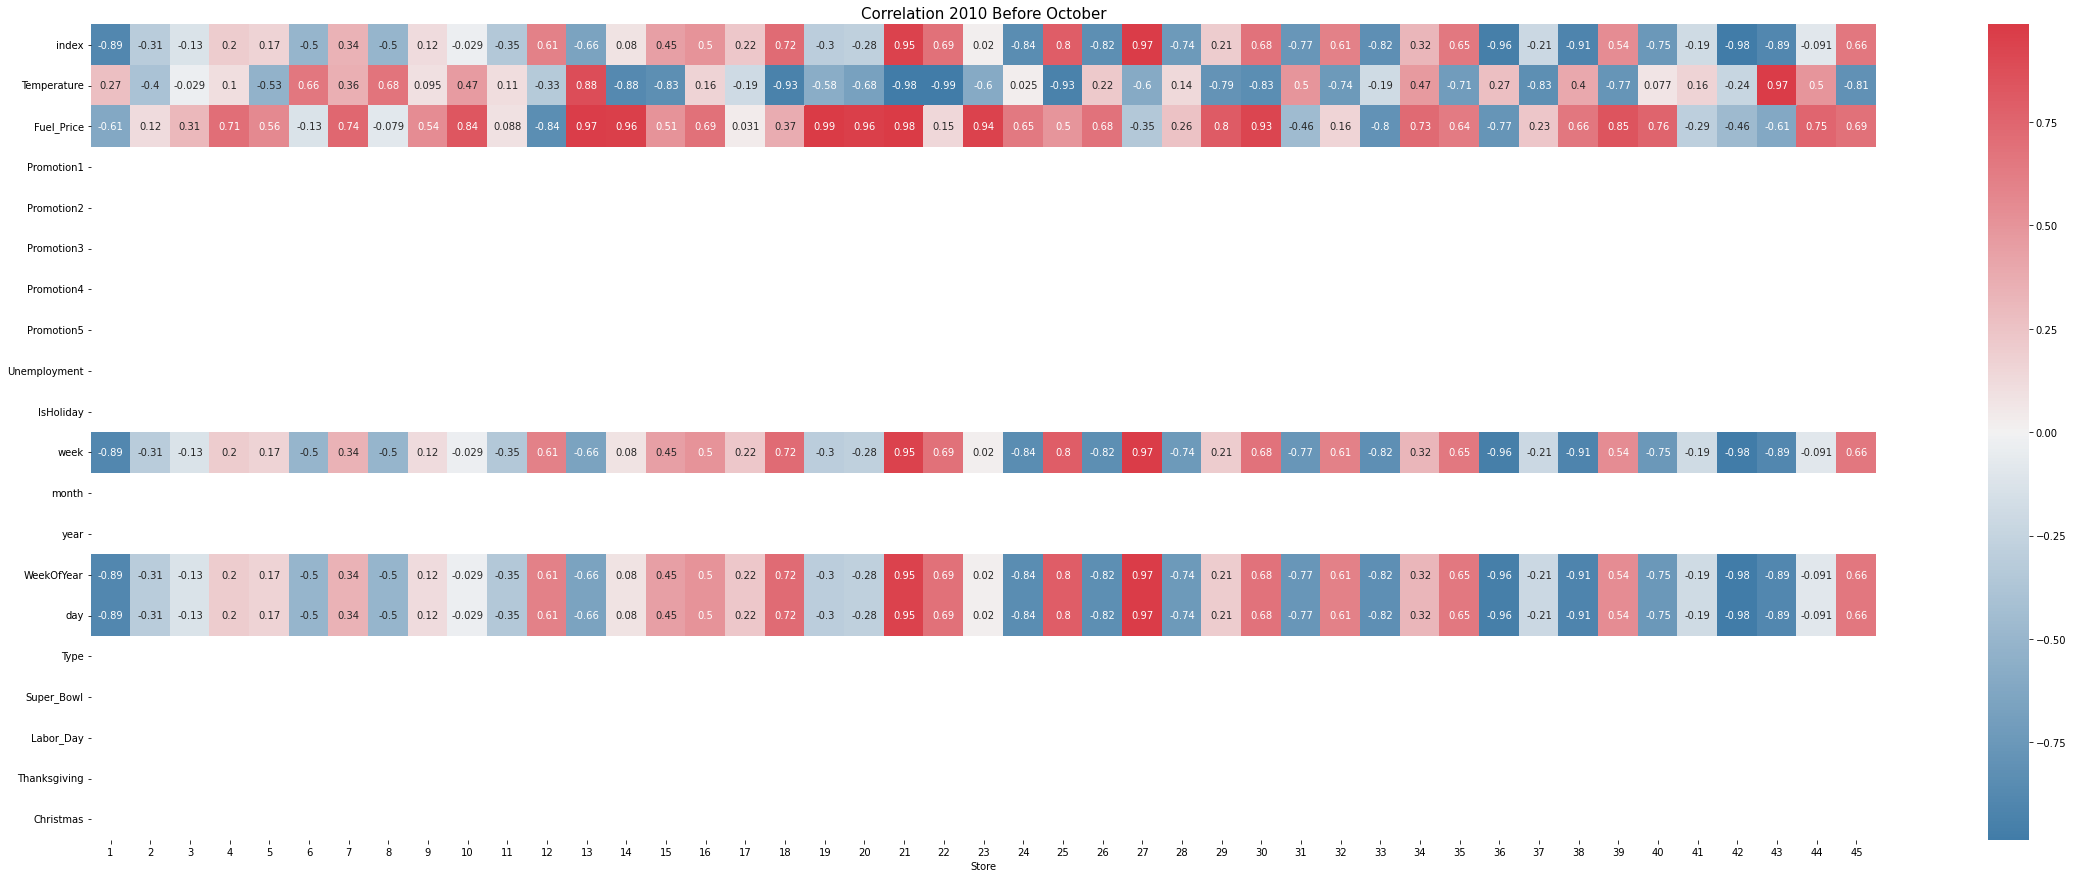

In [80]:
# Analyze Correlation by Store 
# 10월 이전만 한 이유는 12년경우 10월 이후가 없기 때문이다.
corr = []
for num in range(1,46):
    co = train[(train.Store==num) & (train.year==2011) & (train.month == 10)]
    co = co.reset_index()
    num_corr = co.corr()['Weekly_Sales']
    num_corr = num_corr.drop(['id','Store','Weekly_Sales'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(1,46))

f, ax = plt.subplots(figsize=(40, 15))
plt.title("Correlation 2010 Before October", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax, annot=True)
plt.xlabel('Store')
plt.show()
#%%

## 12년도전체를 상관관계로 확인해보자

Text(0.5, 1.0, 'Correlation Matrix only 2012')

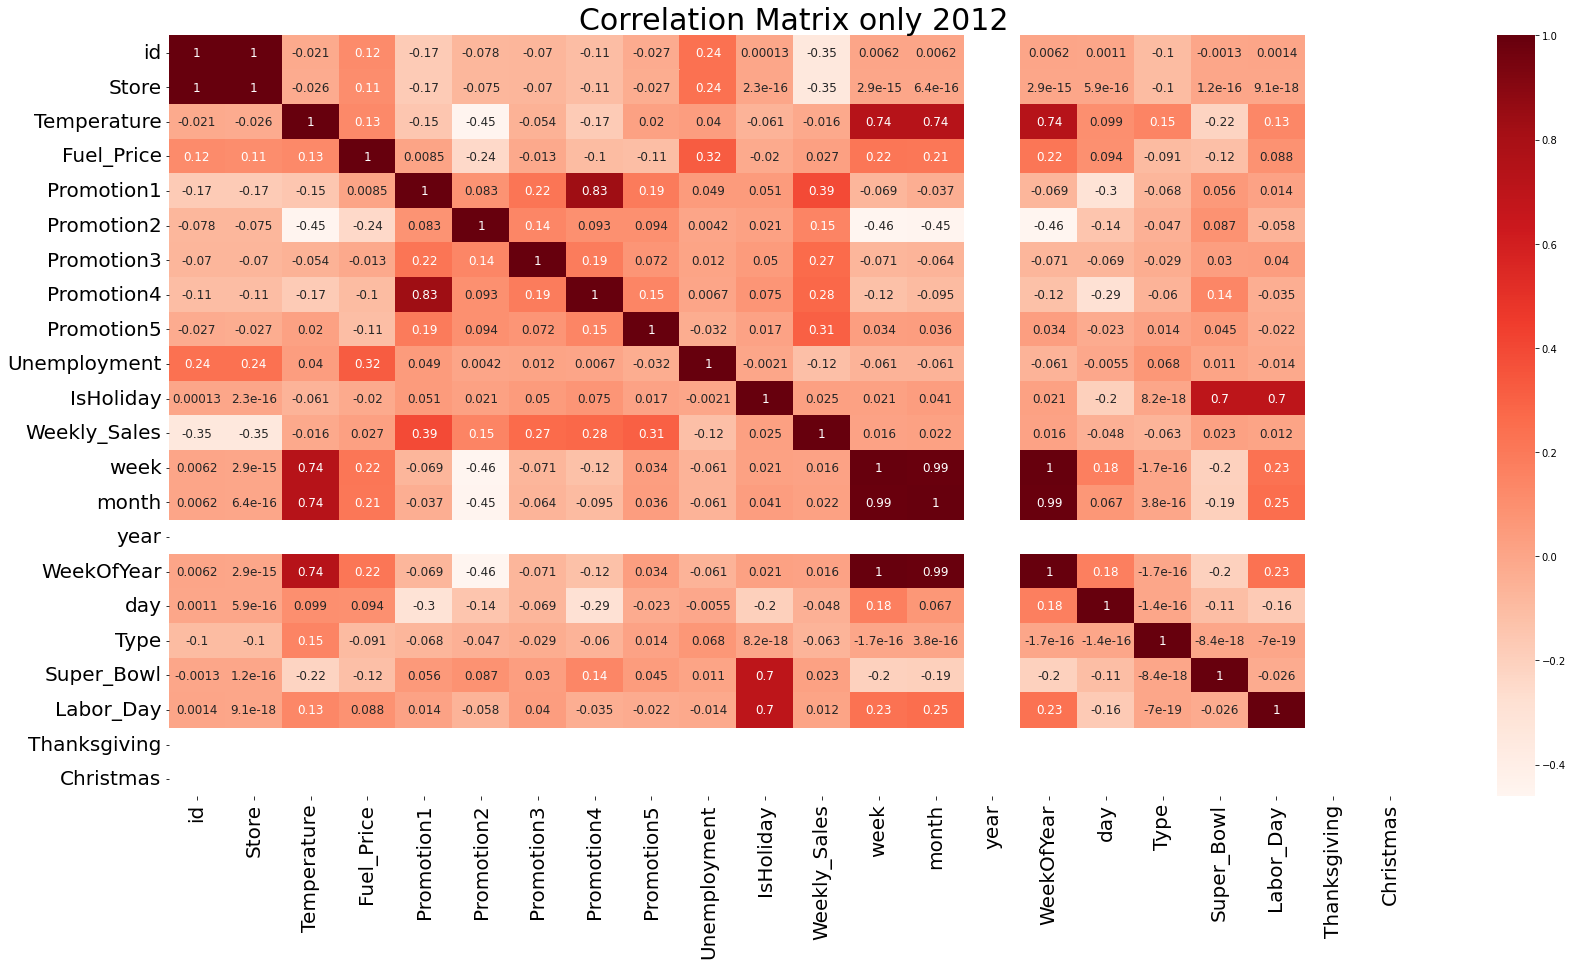

In [85]:
plt.figure(figsize=(28,14))
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)
temp = train[train.year==2012]
sns.heatmap(temp.corr(), cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix only 2012', fontsize=30)

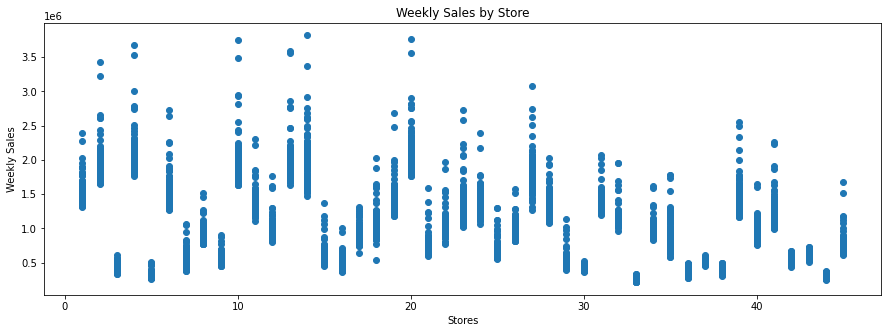

In [87]:
x = train['Store']
y = train['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

plt.figure(figsize=(30,10))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=train)

## Log Transform 확인
데이터는 정규분포를 만족할 수록 좋은 결과를 보여준다.

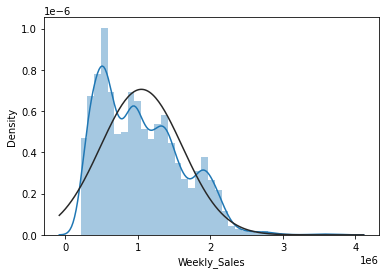

In [88]:
from scipy import stats

sns.distplot(train['Weekly_Sales'], fit=stats.norm)

In [90]:
sns.distplot(np.log1p(train['Weekly_Sales']), fit=stats.norm)  # log1p 를 취해서 정규분포로 만든다. log()가 아닌 이유는 무한대 발생가능을 제거 

## 스케일링 전 저장

In [92]:
train.to_csv("/content/drive/MyDrive/dacon_shopping2/shopping2_git/dataset/train_set.csv", index = False)
test.to_csv("/content/drive/MyDrive/dacon_shopping2/shopping2_git/dataset/test_set.csv", index = False)

In [94]:
train["Weekly_Sales"] = np.log1p(train["Weekly_Sales"]) 

## 학습을 위한 전처리
MinMaxScaler 를 사용해서 사이즈를 맞춰준다

In [95]:
train = train.drop([ 'id', 'Date', 'WeekOfYear'], axis = 1) # 필요없는 컬럼 제거
test = test.drop(['id', 'Date', 'WeekOfYear'], axis = 1)

temp = train["Weekly_Sales"] # 스케일링전 임시 저장 
scaler = MinMaxScaler()

scaler.fit(train)
train_scaled = scaler.transform(train)
real_data = pd.DataFrame(data=train_scaled, columns= train.columns)

train = train.drop("Weekly_Sales", axis = 1)
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
scaler2.fit(train)
train_scaled = scaler2.transform(train)

test_scaled = scaler2.transform(test)
data_test = pd.DataFrame(data=test_scaled, columns= test.columns)
real_data["Original_Weekly_Sales"] = temp


## 모델 학습

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics, ensemble, linear_model
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

train_df = real_data.copy()
test_df = data_test.copy()

# 스케일러를 위한 Original train set 불러오기
original_train_df = train.copy()
original_test_df = test.copy()

scaler_for_weekly_sales = MinMaxScaler()
scaler_for_weekly_sales.fit(train_df['Original_Weekly_Sales'].values.reshape(-1, 1))

# X_train
X_train = train_df[train_df.month <= 0.85]
y_train = X_train.Weekly_Sales

# 앞의분 분석에서 중요하다고 생각했던 feature들을 따로 모았습니다. 
feature = ['Store', 'Type', 'year', 'week','IsHoliday', 'month', 'day']

## GridSearch  하이퍼파라미터 찾기 

In [105]:
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate':[0.1], #so called `eta` value
              'max_depth': [50],
              'min_child_weight': [4],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators':[30000]
              } 
xgb = XGBRegressor(random_state = 2022)

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 10,
                        scoring = 'neg_mean_absolute_error',
                        n_jobs = 5,
                        verbose=3
                        )

xgb_grid.fit(X_train[feature], y_train)
best_model = xgb_grid.best_estimator_
print("BEST SCORE : {}".format(xgb_grid.best_score_))
print("BEST PARAMETER : {}".format(xgb_grid.best_params_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
BEST SCORE : -0.20609589369000275
BEST PARAMETER : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 50, 'min_child_weight': 4, 'n_estimators': 30000, 'objective': 'reg:squarederror', 'subsample': 0.8}


토크에서 이런 예측 대회로는 과적합이 가장 좋다고해서 육안으로 max_depth와 n_estimator가 최대가 되는 파라미터를 찾았습니다. 그 값들이 이 값들이었습니다. 많은 시행 착오가 있었지만 가장 좋았던 파라미터만을 이 코드에서는 제시하겠습니다.

In [108]:
prediction = best_model.predict(test_df[feature])
prediction = scaler_for_weekly_sales.inverse_transform(prediction.reshape(-1, 1))
prediction = np.expm1(prediction)
test_df["Weekly_Sales"] = prediction
original_test_df["Weekly_Sales"] = prediction

In [109]:
print(prediction)

[[1644532.5 ]
 [1492791.2 ]
 [1530767.6 ]
 [1492392.6 ]
 [1870352.5 ]
 [1760564.2 ]
 [1828826.5 ]
 [1825642.9 ]
 [ 411790.03]
 [ 388931.28]
 [ 410716.2 ]
 [ 408488.8 ]
 [2184304.5 ]
 [2042946.9 ]
 [2196849.5 ]
 [2184012.8 ]
 [ 327296.44]
 [ 298015.5 ]
 [ 312728.03]
 [ 323871.3 ]
 [1490314.8 ]
 [1406007.2 ]
 [1429125.6 ]
 [1398754.5 ]
 [ 539590.4 ]
 [ 517631.88]
 [ 533569.5 ]
 [ 546325.9 ]
 [ 931393.5 ]
 [ 871664.2 ]
 [ 903950.5 ]
 [ 909652.  ]
 [ 572326.9 ]
 [ 530488.1 ]
 [ 553229.4 ]
 [ 563403.75]
 [1733371.8 ]
 [1667111.9 ]
 [1689208.5 ]
 [1750774.4 ]
 [1366039.8 ]
 [1274684.9 ]
 [1314079.6 ]
 [1319390.1 ]
 [ 963518.5 ]
 [ 918370.4 ]
 [ 930883.75]
 [ 996948.25]
 [2096374.2 ]
 [1984508.1 ]
 [2010401.4 ]
 [2019958.6 ]
 [1838619.6 ]
 [1668763.  ]
 [1669633.8 ]
 [1751050.  ]
 [ 571754.  ]
 [ 539247.75]
 [ 583611.7 ]
 [ 586117.2 ]
 [ 495704.88]
 [ 492621.38]
 [ 542806.4 ]
 [ 527559.44]
 [ 980800.56]
 [ 929732.1 ]
 [ 913681.  ]
 [ 981441.5 ]
 [1071712.6 ]
 [1060003.9 ]
 [1086157.9 ]
 [1114